In [2]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting Up Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Data Preprocessing

## Data Cleaning

In [4]:
def find_corrupted_images(folder_path):
    corrupted_files = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            with Image.open(file_path) as img:
                img.verify()  # Verify if image is not corrupted
        except (IOError, SyntaxError):
            corrupted_files.append(file_name)
    return corrupted_files

In [5]:
import hashlib
def find_duplicate_images(folder_path):
    hashes = {}
    duplicates = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
        if file_hash in hashes:
            duplicates.append((file_name, hashes[file_hash]))
        else:
            hashes[file_hash] = file_name
    
    return duplicates


In [6]:
def delete_files(folder_path, file_list, reason=""):
    """Deletes the specified files from the folder and prints status."""
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        try:
            os.remove(file_path)
            print(f"Deleted {reason}: {file_name}")
        except Exception as e:
            print(f"Error deleting {file_name}: {e}")

In [7]:
def delete_duplicate_images(duplicates, folder_path):
    for file1, file2 in duplicates:
        file_to_delete = file_path = os.path.join(folder_path, file1)
        if os.path.exists(file_to_delete):
            os.remove(file_to_delete)
            print(f"Deleted: {file_to_delete}")
        else:
            print(f"File not found: {file_to_delete}")

In [8]:
def check_naming_consistency(folder_path):
    inconsistent_files = []
    for file_name in os.listdir(folder_path):
        if not (file_name.startswith("1_") or file_name.startswith("0_")) or not file_name.endswith(".jpg"):
            inconsistent_files.append(file_name)
    return inconsistent_files

In [9]:
# Set dataset directory
data_dir = "Food-5K/training"
# Check for anomalies
corrupted = find_corrupted_images(data_dir)
duplicates = find_duplicate_images(data_dir)
inconsistent_names = check_naming_consistency(data_dir)
print(f"Corrupted Images: {corrupted if corrupted else 'None'}")
print(f"Duplicate Images: {duplicates if duplicates else 'None'}")
print(f"Inconsistent Filenames: {inconsistent_names if inconsistent_names else 'None'}")

Corrupted Images: None
Duplicate Images: None
Inconsistent Filenames: None


In [10]:
# Delete corrupted and inconsistent files
delete_files(data_dir, corrupted, reason="Corrupted")
delete_files(data_dir, inconsistent_names, reason="Inconsistent Filename")
# Remove duplicates, keeping only one copy
delete_duplicate_images(duplicates,data_dir)
print("Cleanup completed successfully.")

Cleanup completed successfully.


In [11]:
# Check for anomalies
corrupted = find_corrupted_images(data_dir)
duplicates = find_duplicate_images(data_dir)
inconsistent_names = check_naming_consistency(data_dir)
print(f"Corrupted Images: {corrupted if corrupted else 'None'}")
print(f"Duplicate Images: {duplicates if duplicates else 'None'}")
print(f"Inconsistent Filenames: {inconsistent_names if inconsistent_names else 'None'}")

Corrupted Images: None
Duplicate Images: None
Inconsistent Filenames: None


# Data Wrangling

In [12]:
class FoodDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = []

        for file_name in os.listdir(folder_path):
            if file_name.endswith(".jpg"):
                label = 1 if file_name.startswith("1") else 0  # 1_xxx.jpg => Food, 0_xxx.jpg => Non-Food
                self.images.append((file_name, label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name, label = self.images[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

## Data Distribution

In [13]:
from collections import Counter
def plot_class_distribution(dataset, title="Class Distribution"):
    """Plots the distribution of classes in the dataset."""
    labels = [label.item() for _, label in dataset]  # Convert tensor labels to integers
    class_counts = Counter(labels)  # Count occurrences of each class

    # Convert to lists for plotting
    classes = ["Food" if key == 1 else "Non-Food" for key in class_counts.keys()]
    counts = list(class_counts.values())

    # Print actual class counts
    print("Class Counts:", dict(class_counts))

    # Plot the correct distribution
    plt.figure(figsize=(7, 5))
    sns.barplot(x=classes, y=counts, palette="viridis")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Data Normalization and Augmentation

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading Data

In [15]:
data_dir = "Food-5K"
train_dataset = FoodDataset(folder_path=f"{data_dir}/training", transform=train_transform)
val_dataset = FoodDataset(folder_path=f"{data_dir}/validation", transform=val_test_transform)
test_dataset = FoodDataset(folder_path=f"{data_dir}/evaluation", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 2990, Validation: 1000, Test: 1000


# Data Visualization

Class Counts: {0: 1495, 1: 1495}


C:\Users\Tayyab Anees\AppData\Local\Temp\ipykernel_20968\2749457443.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


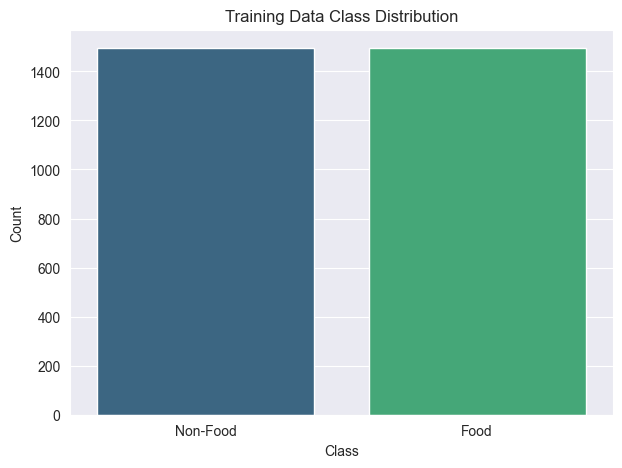

Class Counts: {0: 500, 1: 500}


C:\Users\Tayyab Anees\AppData\Local\Temp\ipykernel_20968\2749457443.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


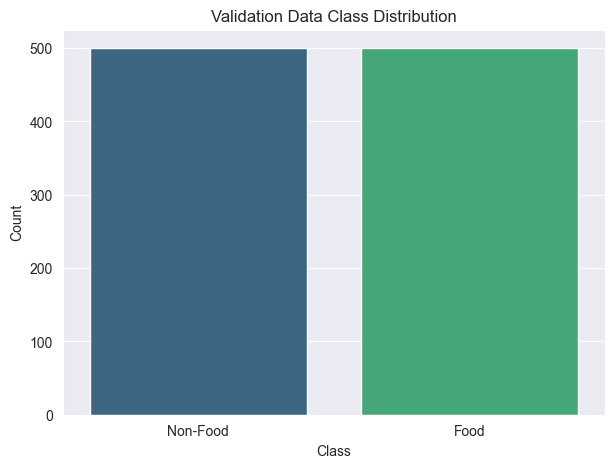

Class Counts: {0: 500, 1: 500}


C:\Users\Tayyab Anees\AppData\Local\Temp\ipykernel_20968\2749457443.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette="viridis")


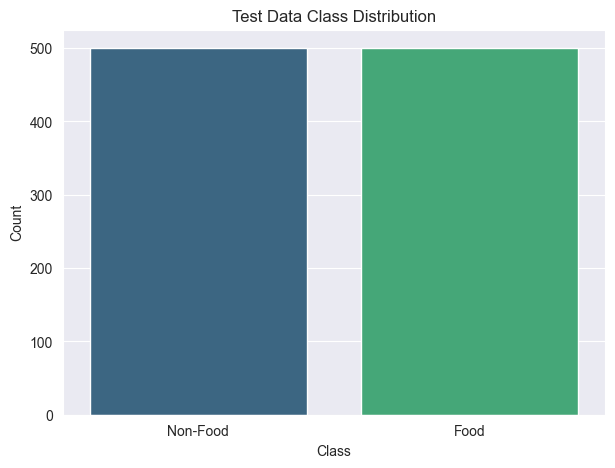

In [16]:
# Example usage
plot_class_distribution(train_dataset, title="Training Data Class Distribution")
plot_class_distribution(val_dataset, title="Validation Data Class Distribution")
plot_class_distribution(test_dataset, title="Test Data Class Distribution")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02352938..1.0696037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


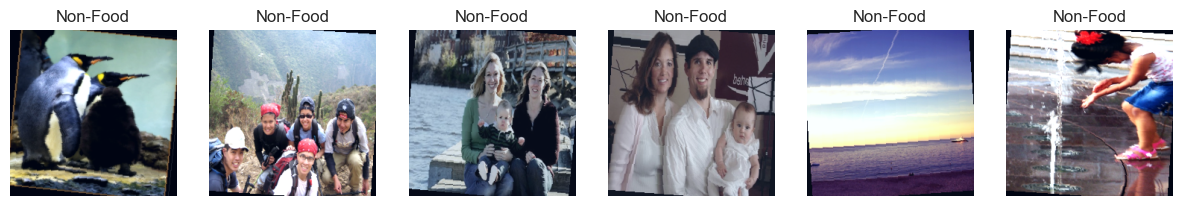

In [17]:
def show_sample_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert from tensor to numpy
        img = img * 0.229 + 0.485  # Unnormalize (approximate)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title("Food" if label == 1 else "Non-Food")
    plt.show()

show_sample_images(train_dataset)

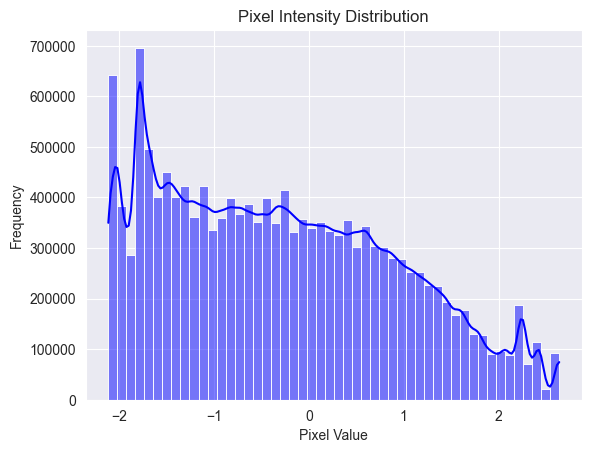

In [18]:
# Pixel Intensity Distribution
pixels = []
for i in range(100):  # Sample 100 images for pixel distribution
    img, _ = train_dataset[i]
    pixels.extend(img.flatten().numpy())

sns.histplot(pixels, bins=50, kde=True, color='blue')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Exploratory Data Analysis and Visualization

In [19]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from PIL import Image

In [20]:
def plot_class_distribution_pie(dataset, title="Class Distribution (Pie Chart)"):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)

    classes = ["Food" if key == 1 else "Non-Food" for key in class_counts.keys()]
    counts = list(class_counts.values())
    
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#ff9999'])
    plt.title(title)
    plt.axis('equal')
    plt.show()

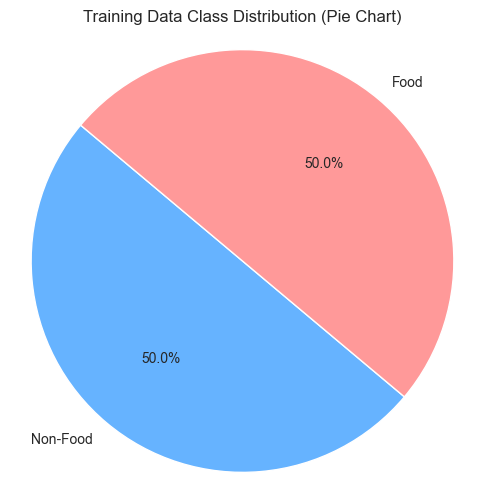

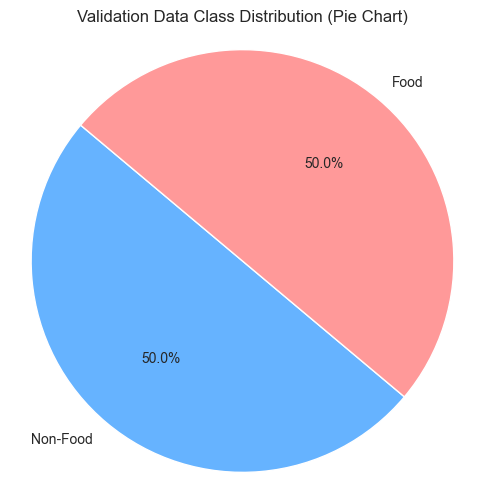

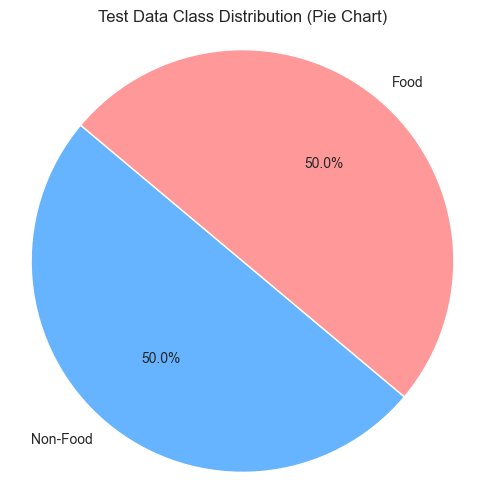

In [21]:
plot_class_distribution_pie(train_dataset, title="Training Data Class Distribution (Pie Chart)")
plot_class_distribution_pie(val_dataset, title="Validation Data Class Distribution (Pie Chart)")
plot_class_distribution_pie(test_dataset, title="Test Data Class Distribution (Pie Chart)")

In [22]:
image_sizes = []
for img_name, _ in train_dataset.images:
    img_path = os.path.join(train_dataset.folder_path, img_name)
    img = Image.open(img_path)
    image_sizes.append(img.size)

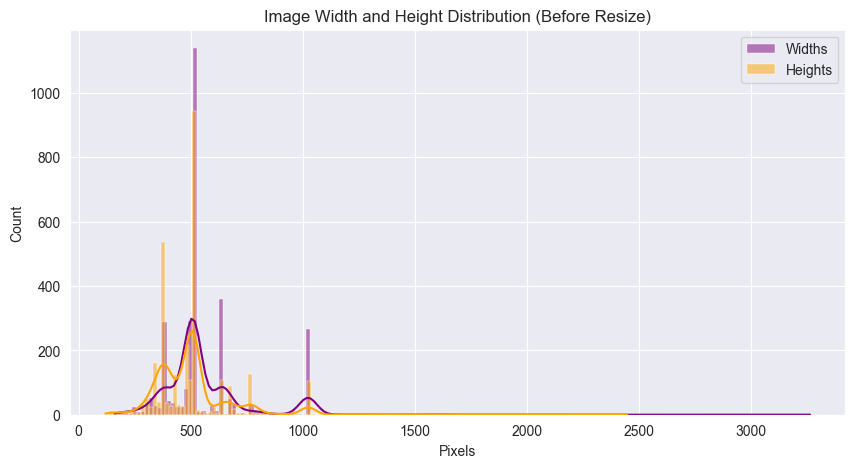

In [23]:
# Convert to width and height
widths, heights = zip(*image_sizes)
plt.figure(figsize=(10,5))
sns.histplot(widths, color="purple", label="Widths", kde=True)
sns.histplot(heights, color="orange", label="Heights", kde=True)
plt.legend()
plt.title("Image Width and Height Distribution (Before Resize)")
plt.xlabel("Pixels")
plt.show()

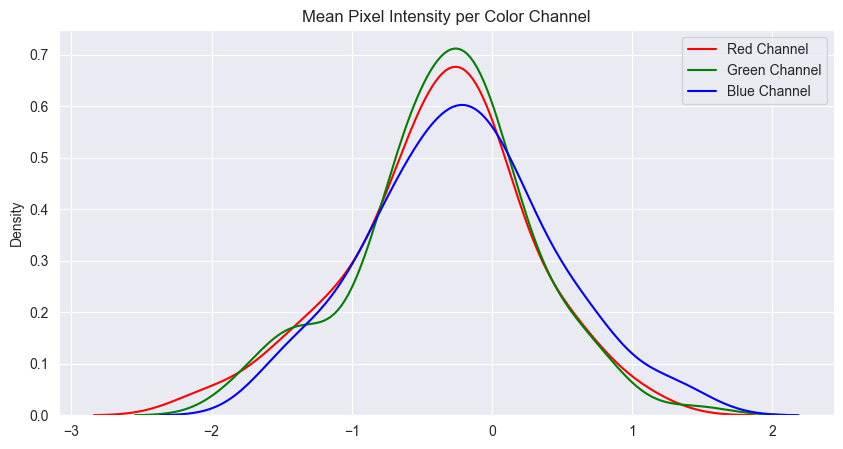

In [24]:
r_means, g_means, b_means = [], [], []

for i in range(100):  # Sample 100 images
    img, _ = train_dataset[i]
    r_means.append(img[0].mean().item())
    g_means.append(img[1].mean().item())
    b_means.append(img[2].mean().item())

plt.figure(figsize=(10,5))
sns.kdeplot(r_means, label='Red Channel', color='r')
sns.kdeplot(g_means, label='Green Channel', color='g')
sns.kdeplot(b_means, label='Blue Channel', color='b')
plt.title("Mean Pixel Intensity per Color Channel")
plt.legend()
plt.show()

C:\Users\Tayyab Anees\AppData\Local\Temp\ipykernel_20968\2635038392.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Label', y='Pixel_Mean', data=df, palette="coolwarm")


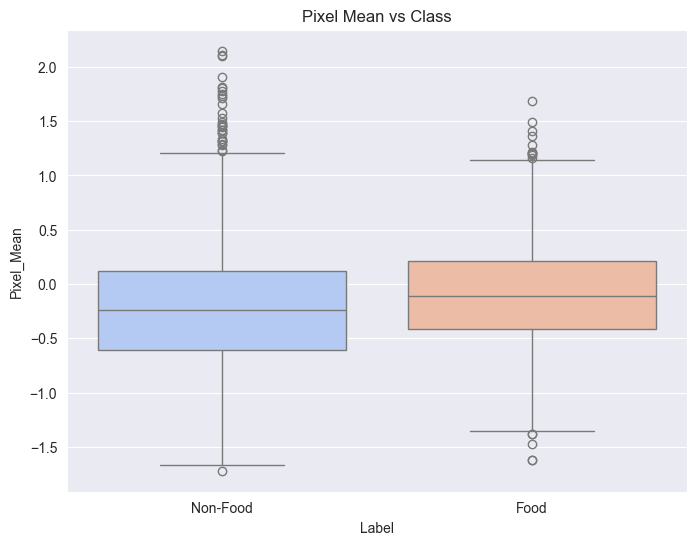

In [29]:
import pandas as pd
pixel_means = []
labels = []

for i in range(2800):
    img, label = train_dataset[i]
    pixel_means.append(img.mean().item())
    labels.append(label.item())

df = pd.DataFrame({
    'Pixel_Mean': pixel_means,
    'Label': labels
})

plt.figure(figsize=(8,6))
sns.boxplot(x='Label', y='Pixel_Mean', data=df, palette="coolwarm")
plt.xticks([0,1], ["Non-Food", "Food"])
plt.title("Pixel Mean vs Class")
plt.show()

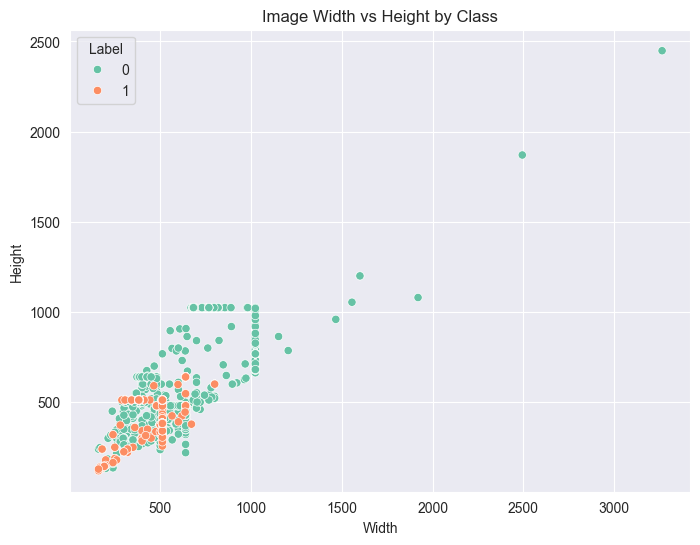

In [32]:
width_height_labels = []
for img_name, label in train_dataset.images:
    img_path = os.path.join(train_dataset.folder_path, img_name)
    img = Image.open(img_path)
    width_height_labels.append((img.width, img.height, label))

df_sizes = pd.DataFrame(width_height_labels, columns=["Width", "Height", "Label"])

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_sizes, x="Width", y="Height", hue="Label", palette="Set2")
plt.title("Image Width vs Height by Class")
plt.show()

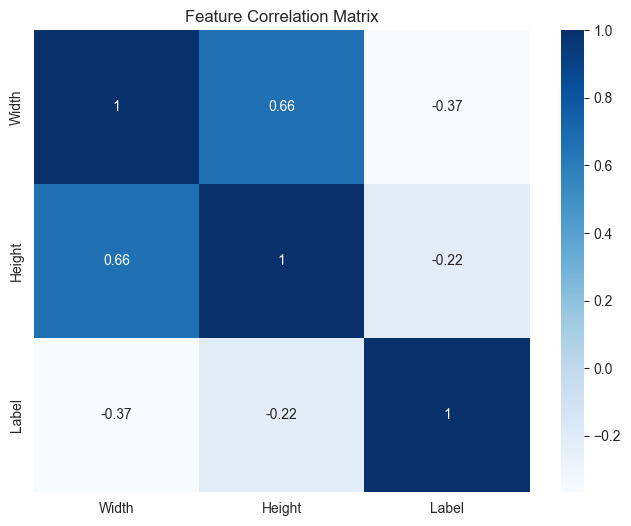

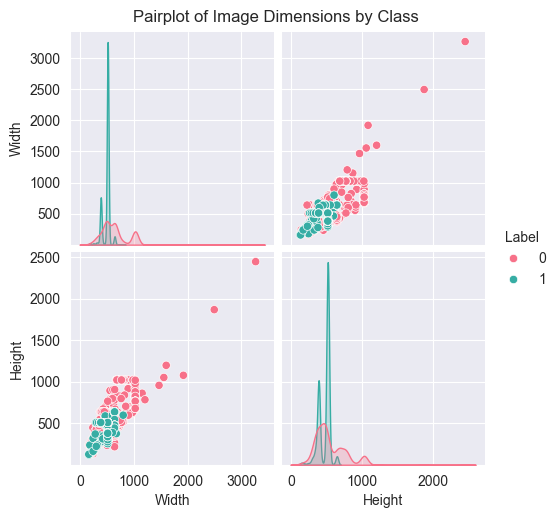

In [33]:
correlation = df_sizes.corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title("Feature Correlation Matrix")
plt.show()

# %% [markdown]
# ### 4.2 🌀 Pairplot of Features

# %%
sns.pairplot(df_sizes, hue="Label", palette="husl")
plt.suptitle("Pairplot of Image Dimensions by Class", y=1.02)
plt.show()

In [36]:
df_sizes = pd.DataFrame(width_height_labels, columns=["Width", "Height", "Label"])

In [37]:
# Calculate and print statistics for Width, Height, and Pixel Mean
print("📏 Image Size Statistics:")

for col in ['Width', 'Height']:
    mean = df_sizes[col].mean()
    median = df_sizes[col].median()
    std_dev = df_sizes[col].std()
    print(f"\n{col}")
    print(f"• Mean: {mean:.2f}")
    print(f"• Median: {median:.2f}")
    print(f"• Std Deviation: {std_dev:.2f}")

print("\n🎨 Pixel Mean Statistics:")

for col in ['Pixel_Mean']:
    mean = df[col].mean()
    median = df[col].median()
    std_dev = df[col].std()
    print(f"\n{col}")
    print(f"• Mean: {mean:.2f}")
    print(f"• Median: {median:.2f}")
    print(f"• Std Deviation: {std_dev:.2f}")


📏 Image Size Statistics:

Width
• Mean: 557.91
• Median: 512.00
• Std Deviation: 194.78

Height
• Mean: 500.78
• Median: 512.00
• Std Deviation: 165.29

🎨 Pixel Mean Statistics:

Pixel_Mean
• Mean: -0.15
• Median: -0.17
• Std Deviation: 0.55
